
  **HSR Simulation and Optimization**

**INTRODUCTION :-**

Simulation process is designed determine the throughput of trains running between 4 stations on HSR line for 60 min. High Speed trains never run in perfect ideal scenario, various extrenal factors impacts the speed and movement of the train in real world scenario. Strong winds heavily impacts overall traveling time of High Speep trains, which makes it an imparotant factor to be considered while designing the simulation for High speed trains. In Refernce with Beaufort wind force scale values 5-10 is selected. Using the values of this impact factor is calculated, overall which will affect the movement of trains in HSR line. Also, variablity in dwell time is considered which is caused due to fluctuation in movement of passangers.

**ASSUMPTIONS :-**

As stated in problem statement, minimum 2 blocks distance should be maintanined. As a train can run constantly at full speed if there is always at least one free block ahead. Also, train is only allowed to enter a block, when there is no other train in the block and the entry signal is green. When a train enters a block the entry signal switches to red. The entrance signal switches back to green 5 seconds after the end of the train has left the block.

**HIGH SPEED TRAIN DETAILS :-**

max speed = 83.3 m/s (300 km/hr)
0 - 300 km/h

acceleration = 0.72 m/s^2\

distance = 4820 m
time = 115.7 s

300 - 0 km/h

deceleration = 0.36 m/s^2 (Energy optimal deceleration)\

distance = 9640 m
time = 231.4 s

**OBJECTIVE :-**

**Part 1: Simulation Objectives**

> To create a simulation for section of the high-speed line under assumption of a number k of signalling blocks.


> Depending on the number of signalling blocks simulate the throughput of trains.





**Part 2: Optimization Objectives**


> Determine K optimal number of blocks and N optimal number of trains (Kopt,Nopt)

> Minimise the overall average traveling time

> Maximise the throughput of passengers in peak hours.






**IMPLEMENTATION :-**

Interactive simulation is designed for given problem statement. Designed simulation takes three values as input from user, number of trains, number of blocks between two stations, and if want to induce variablity due to wind. Based on these inputs from user output of simulation calculated.

------------------------------------------------------------------------------------------------------------------------------------------------------------

**Import Libraries**

Implementation of this simulation is done using python library Simpy

In [1]:
pip install simpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import simpy
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

**HS2 Station Data**

A dataframe is created from the infromation given in the dataset. In order to better understand the information regarding HSR line

In [3]:
hs2_data = pd.DataFrame(columns=['FROM', 'TO', 'TIME_SEC', 'BLOCKS', 'DISTANCE'])

records = [pd.Series(['Station 1', 'Station 2', 300, 1, 'NA'], index=hs2_data.columns ) ,
                pd.Series(['Station 2', 'Station 3', 1860, 'NA', 145000], index=hs2_data.columns ) ,
                pd.Series(['Station 3', 'Station 4', 540, 2, 'NA'], index=hs2_data.columns ) ]

hs2_data = hs2_data.append(records, ignore_index=True)
hs2_data

,FROM,TO,TIME_SEC,BLOCKS,DISTANCE
0,Station 1,Station 2,300,1,NA
1,Station 2,Station 3,1860,NA,145000
2,Station 3,Station 4,540,2,NA


**Simulation Process**

Various utility functions are written for the puropse of calculating and converting values

In [4]:
#To convert distance from m scale to Km
def m_to_km(x):
  return round(x/1000, 1)

#To formate Time in HH:mm:ss
def hhmmss(t):
  t=int(t)
  return f"{t//3600:02d}:{(t%3600)//60:02d}:{t%60:02d}"

#To convert time from sec scale to min
def s_to_m(t):
  return round(t/60,2)

#Returns Distance Traveled and Time of Travel
'''
t = time  | d = distance  | a = acceleration  | v = velocity  | s = speed

t = v/a
d = (a*t*t)/2
s = d/t
'''
def get_travelTimeDistance(a, v):
    t = round(v/a,1)
    d = round((a*t*t)/2)
    return [t, d]

def get_travelTime(s, d):
    t = round(d/s, 1)
    return t

def get_travelDistance(s, t):
    d = round(s*t)
    return d

**Train()** class is created to handle and capture all information related to a moving train in their individual train objects

In [5]:
class Train(object):
  def __init__(self, train_num):
    self.number = train_num
    self.pos = 0
    self.traveled_distance = 0
    self.start_time = 0
    self.end_time = 0
    self.travel_duration = 0
    self.wait_time = 0

**HS2()** class handle information on movement of all trains and pre-signals

In [6]:
class Hs2(object):
  def __init__(self, num_of_blocks, num_of_trains, induce_winds, pass_dwell):
    self.hs2_data = hs2_data
    self.st23_num_of_blocks = num_of_blocks
    self.st23_block_length = round(hs2_data.loc[1][4]/num_of_blocks,1)
    self.block_list = [0]*(hs2_data.loc[0][3] + num_of_blocks + hs2_data.loc[2][3])
    self.num_ip_trains = num_of_trains
    self.train_count = 0
    self.total_trains = 0
    self.winds = induce_winds
    self.dwell = pass_dwell


  def signal_control(self):
    #global block_list
    if self.train_count < self.num_ip_trains and self.block_list[0] == 0: #self.block_list[1] == 0:
      #print('s_dharesh0')
      return True
    else:
      #print('s_dharesh1')
      return False
  

  def new_train(self, train_num):
    return Train(train_num)
  
  def strong_wind_impact(self):
    if self.winds == 1:
      return 2.5*random.randint(5,10) #increase in travel time by 1.5 * value in scale
    else:
      return 0

  def dwell_time(self):
    if self.dwell == 1:
      return random.randint(10,20) #increase in travel time by 1.5 * value in scale
    else:
      return 0

**update_state()** function captures the traveling information of each trains per iteration and updates its live position and total travelling time

In [7]:
def update_state(env, t):
    global train_list

    t.end_time = env.now
    t.travel_duration = env.now - t.start_time
    train_list[t.number-1] == t

Global constants

In [8]:
MAX_VELOCITY = 83.3 #m/s
ACCELERATION = 0.72 #m/s^2
DECELERATION = 0.36 #m/s^2
GRN_SIGNAL_AFT_EXIT = 5 #sec

#Global DataFrame is created to store the information of moving trains
df = pd.DataFrame(columns= ['TRAIN', 'STATUS', 'STATION', 'TIME'])
#Global train Lists
train_list = []

**run()** function is the major process of the code. which encapsulates logic of controlling movement of train. Flow of this process is as follows

Train enters HSR line, travels till London Old Oak St. for 5 min.
Variablity is added for time train will halt at staion, in order to handle movement of pasangers.
Variablity of wind is induced between London Old Oak to Birmingham Interchange stations, which will affect the movement of train.
Train check for 2 sunsequent signals, if green, before entering the next block.
If it dosent get 2 green signal it waits for train ahead to pass.

In [9]:
def run(env, hs, t):
  
  global df 

  while t.pos < len(hs.block_list):

    update_state(env, t)
    ########################### travelling between London Euston - London old oak #################################
    if t.pos == 0:                                                  
      #print("dharesh_a",t.pos,t.number,hhmmss(env.now))                                           
      hs.block_list[t.pos] = t.number 
      record = {'TRAIN':t.number, 'STATUS':'DEPARTED', 'STATION':'LONDON EUSTON', 'TIME':hhmmss(env.now)} 
      #print(hs.block_list)
      df = df.append(record, ignore_index=True)
      yield env.timeout(hs.hs2_data.loc[0][2])  
      update_state(env, t)

      record = {'TRAIN':t.number, 'STATUS':'ARRIVED', 'STATION':'LONDON OLD OAK', 'TIME':hhmmss(env.now)} 
      df = df.append(record, ignore_index=True)
      wait = hs.dwell_time()
      t.wait_time += wait
      yield env.timeout(wait)                                                                           #Dwell time, time train is halted at London Old Oak 
      update_state(env, t)

      t.pos += 1
    
    ########################### travelling between London Old Oak - Birmingham Interchange #################################
    elif t.pos > 0 and hs.block_list[t.pos] == 0:#hs.block_list[t.pos+1] == 0:
      if t.pos == 1:                                                                                          #Block Where train starts to accelerate
        #print("dharesh_b",t.pos,t.number,hhmmss(env.now))
        time, distance = get_travelTimeDistance(ACCELERATION,MAX_VELOCITY)                                  
        time += get_travelTime(MAX_VELOCITY,hs.st23_block_length - distance)
        
        hs.block_list[t.pos-1] = 0
        hs.block_list[t.pos] = t.number
        record = {'TRAIN':t.number, 'STATUS':'DEPARTED', 'STATION':'LONDON OLD OAK', 'TIME':hhmmss(env.now)} 
        df = df.append(record, ignore_index=True)
        yield env.timeout(time + GRN_SIGNAL_AFT_EXIT)                                                         #after 5sec of train leaving the block
        update_state(env, t)
                                                                                                              #signal switches back to green                                                                              
        t.pos += 1

      elif t.pos > 1 and t.pos < hs.st23_num_of_blocks:                                                       #Block Where train at max acceleration,
        #print("dharesh_c",t.pos,t.number,hhmmss(env.now))                                                     
        time = get_travelTime(MAX_VELOCITY,hs.st23_block_length)                                              #Impack of Extrenal factor like wind
        time += hs.strong_wind_impact()                                                                       #is introduced, affecting speed of train
        
        hs.block_list[t.pos-1] = 0 
        hs.block_list[t.pos] = t.number                                                                              
        yield env.timeout(time + GRN_SIGNAL_AFT_EXIT) 
        update_state(env, t)
        
        t.pos += 1

      elif t.pos == hs.st23_num_of_blocks:                                                                    #Block where train decelerates to 0, to halt 
        #print("dharesh_d",t.pos,t.number,hhmmss(env.now))                                                    #at Birmingham Interchange station  
        time, distance = get_travelTimeDistance(DECELERATION,MAX_VELOCITY)
        time += get_travelTime(MAX_VELOCITY, hs.st23_block_length - distance)
        
        hs.block_list[t.pos-1] = 0
        hs.block_list[t.pos] = t.number
        yield env.timeout(time) 
        update_state(env, t)

        record = {'TRAIN':t.number, 'STATUS':'ARRIVED', 'STATION':'BIRMINGHAM INTERCHANGE', 'TIME':hhmmss(env.now)} 
        df = df.append(record, ignore_index=True)
        wait = hs.dwell_time()
        t.wait_time += wait
        yield env.timeout(wait)                                                                         #Dwell time, time train is halted at Birmingham Interchange 
        update_state(env, t)

        t.pos += 1

      ########################### travelling between Birmingham Interchange - Birmingham Cruzon #################################
      elif t.pos > hs.st23_num_of_blocks:                                                          
        #print("dharesh_e",t.pos,t.number,hhmmss(env.now))

        hs.block_list[t.pos-1] = 0
        hs.block_list[t.pos] = t.number 
        record = {'TRAIN':t.number, 'STATUS':'DEPARTED', 'STATION':'BIRMINGHAM INTERCHANGE', 'TIME':hhmmss(env.now)} 
        df = df.append(record, ignore_index=True)                                                                      
        yield env.timeout(hs.hs2_data.loc[2][2]/2)                                      
        update_state(env, t)

        t.pos += 1

        hs.block_list[t.pos-1] = 0
        hs.block_list[t.pos] = t.number
        yield env.timeout(hs.hs2_data.loc[2][2]/2)
        update_state(env, t)

        record = {'TRAIN':t.number, 'STATUS':'ARRIVED', 'STATION':'BIRMINGHAM CRUZON', 'TIME':hhmmss(env.now)} 
        df = df.append(record, ignore_index=True)
        hs.block_list[t.pos] = 0

        break
    
    else:
      yield env.timeout(1)                                                                                     #Inner clock
      t.wait_time += 1

**train_simulation()** process handles the entry of new train into HSR line, new run() process is created every time a new train is created.

In [10]:
def train_simulation(env, hs):
  print('Simulation Running...',f'\nFor {len(hs.block_list)} blocks and {hs.num_ip_trains} input trains', 
        f'each block between LONDON OLD OAK and BIRMINGHAM INTERCHANGE is {m_to_km(hs.st23_block_length)} km in length.')
  
  global train_list
  global df 
  train_list = []  
  df.drop(df.index, inplace=True)
  
  while True:

    if hs.signal_control():                             # Check for green signal before starting new train
      hs.train_count += 1
      train = hs.new_train(hs.train_count)              # creating new train object
      train.start_time = env.now
      train_list.append(train)
      env.process(run(env, hs, train))                  # Start new train process
    
    
    yield env.timeout(1)                                #outer clock running per sec
    


**main()** function validates the input, sets environment for simulation and end of simulation clock time, we are running simulation for 1 hr.

In [11]:
def main(num_of_blocks,num_of_trains,induce_winds, pass_dwell):
  #create class object
  hs = Hs2(num_of_blocks, num_of_trains, int(induce_winds), int(pass_dwell))
  #Setup enviornment
  env = simpy.Environment()
  #initiate simulation
  env.process(train_simulation(env,hs))
  #run until 1 hr (3600 sec)
  env.run(until=3600)

If variablity due to wind is induced, total travel time of trains will always differ in each run

In [12]:
#Take user inputs
n_blocks = input('Enter number of blocks to be laid between (London Old Oak - Brimingham Interchange) line of 145 km = \n')
n_trains = input('Enter number of train = \n')
winds = input('Enter number 1 if want to induce variablity due to wind or 0 if not\n')
pass_dwell = input('Enter number 1 if want to induce variablity due to passanger movement or 0 if not\n')

#Validating input
params = [n_blocks, n_trains]
if all(str(i).isdigit() and int(i)>0 for i in params):                    #Check is values are digit and greater than 0
  n_blocks, n_trains = [int(x) for x in params]
else:
  print('Default, Simulation starts with 10 Block and 10 Trains')
  n_blocks, n_trains = 10,10

if int(winds) and int(pass_dwell) in [0,1]:                                                   #Checks choice for wind variablity entered is correct
  if int(winds) and int(pass_dwell) == 1:
    print("\n***Variablity in speed of trains due to WIND and Passanger Movement is induced in simulation\n\n")
else: 
  winds, pass_dwell = 0, 0


if __name__ == "__main__":
  main(n_blocks, n_trains, winds, pass_dwell) 

Enter number of blocks to be laid between (London Old Oak - Brimingham Interchange) line of 145 km = 
10
Enter number of train = 
15
Enter number 1 if want to induce variablity due to wind or 0 if not
1
Enter number 1 if want to induce variablity due to passanger movement or 0 if not
1

***Variablity in speed of trains due to WIND and Passanger Movement is induced in simulation


Simulation Running... 
For 13 blocks and 15 input trains each block between LONDON OLD OAK and BIRMINGHAM INTERCHANGE is 14.5 km in length.


**Verification of Simulation Results**

In [13]:
df

,TRAIN,STATUS,STATION,TIME
0,1,DEPARTED,LONDON EUSTON,00:00:00
1,1,ARRIVED,LONDON OLD OAK,00:05:00
2,1,DEPARTED,LONDON OLD OAK,00:05:10
3,2,DEPARTED,LONDON EUSTON,00:05:10
4,2,ARRIVED,LONDON OLD OAK,00:10:10
5,2,DEPARTED,LONDON OLD OAK,00:10:29
6,3,DEPARTED,LONDON EUSTON,00:10:29
7,3,ARRIVED,LONDON OLD OAK,00:15:29
8,3,DEPARTED,LONDON OLD OAK,00:15:48
9,4,DEPARTED,LONDON EUSTON,00:15:48


Below data show, movement of individual train between stations.

In [14]:
df[df.TRAIN.eq(1)]

,TRAIN,STATUS,STATION,TIME
0,1,DEPARTED,LONDON EUSTON,00:00:00
1,1,ARRIVED,LONDON OLD OAK,00:05:00
2,1,DEPARTED,LONDON OLD OAK,00:05:10
22,1,ARRIVED,BIRMINGHAM INTERCHANGE,00:40:34
23,1,DEPARTED,BIRMINGHAM INTERCHANGE,00:40:44
32,1,ARRIVED,BIRMINGHAM CRUZON,00:49:44


Below data shows, Start time of each train. Time when new train was introduced into HSR line

In [15]:
df[df.STATION.eq('LONDON EUSTON')]

,TRAIN,STATUS,STATION,TIME
0,1,DEPARTED,LONDON EUSTON,00:00:00
3,2,DEPARTED,LONDON EUSTON,00:05:10
6,3,DEPARTED,LONDON EUSTON,00:10:29
9,4,DEPARTED,LONDON EUSTON,00:15:48
12,5,DEPARTED,LONDON EUSTON,00:21:08
15,6,DEPARTED,LONDON EUSTON,00:26:24
18,7,DEPARTED,LONDON EUSTON,00:31:43
21,8,DEPARTED,LONDON EUSTON,00:36:53
26,9,DEPARTED,LONDON EUSTON,00:42:03
31,10,DEPARTED,LONDON EUSTON,00:47:21


Above data shows, Number of train that completed journey

In [16]:
df[df.STATION.eq('BIRMINGHAM CRUZON')]

,TRAIN,STATUS,STATION,TIME
32,1,ARRIVED,BIRMINGHAM CRUZON,00:49:44
38,2,ARRIVED,BIRMINGHAM CRUZON,00:55:06


**build_train_summary()** creates the summary to all trains that entered into HSR line.

In [17]:
train_summary = pd.DataFrame(columns=['TRAIN','POSITION','TRAVEL_TIME', 'WAIT_TIME'])

def build_train_summary(train_list):
  global train_summary
  train_summary.drop(train_summary.index, inplace=True)
  for t in train_list:
    if t.pos > 1:
      t.travel_duration -= 5*t.pos - 2 #removing signal time, as it dosent add to total travel time

    record = {'TRAIN':t.number, 'POSITION':t.pos+1, 'TRAVEL_TIME':s_to_m(t.travel_duration), 'WAIT_TIME':s_to_m(t.wait_time)}
    train_summary = train_summary.append(record, ignore_index=True) 

In [18]:
build_train_summary(train_list)
train_summary

,TRAIN,POSITION,TRAVEL_TIME,WAIT_TIME
0,1.0,13.0,48.77,0.33
1,2.0,13.0,48.97,0.62
2,3.0,13.0,44.72,0.62
3,4.0,12.0,40.14,0.78
4,5.0,11.0,34.89,0.28
5,6.0,10.0,31.86,0.32
6,7.0,8.0,24.95,0.17
7,8.0,7.0,21.75,0.17
8,9.0,5.0,15.42,0.30
9,10.0,4.0,12.30,0.17


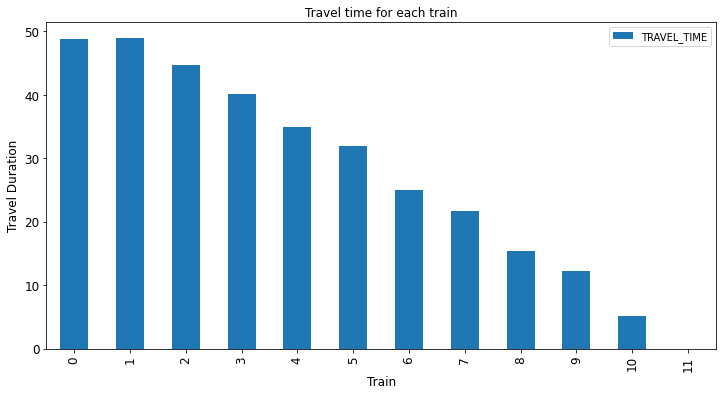

In [19]:
ax = train_summary[['TRAVEL_TIME']].plot(kind='bar', title ="Travel time for each train", figsize=(12, 6), legend=True, fontsize=12)
ax.set_xlabel("Train", fontsize=12)
ax.set_ylabel("Travel Duration", fontsize=12)
plt.show()

Above bar graph shows, Trave time of each train currently running trains as well trains that completed journey.

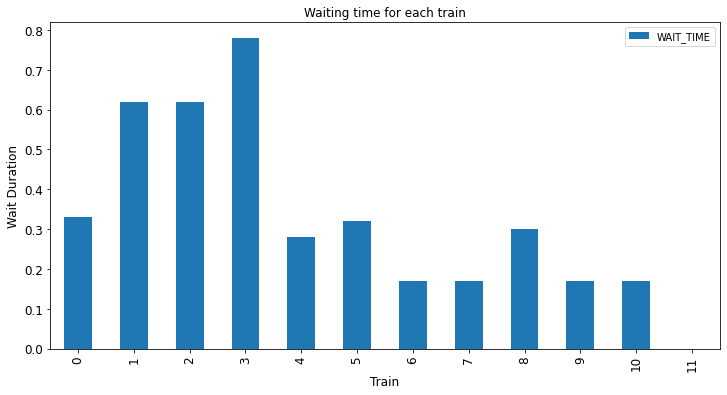

In [20]:
ax = train_summary[['WAIT_TIME']].plot(kind='bar', title ="Waiting time for each train", figsize=(12, 6), legend=True, fontsize=12)
ax.set_xlabel("Train", fontsize=12)
ax.set_ylabel("Wait Duration", fontsize=12)
plt.show()

Above bar graph shows, Wait time of each train currently running trains as well trains that completed journey.

Average of travel time of all trains in HSR line

In [21]:
x = train_summary['TRAVEL_TIME'].mean()
print(f'Overall average travel time of all trains that entered HSR line is {round(x,2)}\n')
avg = train_summary[train_summary.POSITION.eq(13)]
y = avg['TRAVEL_TIME'].mean()
print(f'Average travel time trains that completed journey is {round(y,2)}')

Overall average travel time of all trains that entered HSR line is 27.41

Average travel time trains that completed journey is 47.49


**Optimization**

**get_optimal()** function below calculates average travel time and throughput for all combination of number of trains ranging from (1...20) and number of blocks ranging from (1...15). No variablity due to wind or dwell time due to passanger movement is addded for optimization problem.

In [22]:
optimal = pd.DataFrame(columns=['TRAINS','BLOCKS','OVERALL_AVG_TRAVEL_TIME','THROUGHPUT'])

def get_optimal():
  global train_list
  global optimal
  optimal.drop(optimal.index, inplace=True)
  for i in range(20):
    for j in range(15):
      if i>0 and j>0:
        train_list = []
        main(j,i,0,0)
        build_train_summary(train_list)
        avg = train_summary['TRAVEL_TIME'].mean()
        fin = train_summary[train_summary.POSITION.eq(13)]
        fin_avg = fin['TRAVEL_TIME'].mean()
        record = {'TRAINS':i, 'BLOCKS':j, 'OVERALL_AVG_TRAVEL_TIME':round(avg,2),'THROUGHPUT':len(train_list)}
        optimal = optimal.append(record, ignore_index=True)

In [23]:
get_optimal()

Simulation Running... 
For 4 blocks and 1 input trains each block between LONDON OLD OAK and BIRMINGHAM INTERCHANGE is 145.0 km in length.
Simulation Running... 
For 5 blocks and 1 input trains each block between LONDON OLD OAK and BIRMINGHAM INTERCHANGE is 72.5 km in length.
Simulation Running... 
For 6 blocks and 1 input trains each block between LONDON OLD OAK and BIRMINGHAM INTERCHANGE is 48.3 km in length.
Simulation Running... 
For 7 blocks and 1 input trains each block between LONDON OLD OAK and BIRMINGHAM INTERCHANGE is 36.2 km in length.
Simulation Running... 
For 8 blocks and 1 input trains each block between LONDON OLD OAK and BIRMINGHAM INTERCHANGE is 29.0 km in length.
Simulation Running... 
For 9 blocks and 1 input trains each block between LONDON OLD OAK and BIRMINGHAM INTERCHANGE is 24.2 km in length.
Simulation Running... 
For 10 blocks and 1 input trains each block between LONDON OLD OAK and BIRMINGHAM INTERCHANGE is 20.7 km in length.
Simulation Running... 
For 11 bl

In [24]:
optimal

,TRAINS,BLOCKS,OVERALL_AVG_TRAVEL_TIME,THROUGHPUT
0,1.0,1.0,43.84,1.0
1,1.0,2.0,45.69,1.0
2,1.0,3.0,45.69,1.0
3,1.0,4.0,45.69,1.0
4,1.0,5.0,45.68,1.0
...,...,...,...,...
261,19.0,10.0,28.13,12.0
262,19.0,11.0,28.12,12.0
263,19.0,12.0,28.13,12.0
264,19.0,13.0,28.31,12.0


In [25]:
optimal[optimal.OVERALL_AVG_TRAVEL_TIME == optimal.OVERALL_AVG_TRAVEL_TIME.min()]

,TRAINS,BLOCKS,OVERALL_AVG_TRAVEL_TIME,THROUGHPUT
160,12.0,7.0,27.46,12.0
174,13.0,7.0,27.46,12.0
188,14.0,7.0,27.46,12.0
202,15.0,7.0,27.46,12.0
216,16.0,7.0,27.46,12.0
230,17.0,7.0,27.46,12.0
244,18.0,7.0,27.46,12.0
258,19.0,7.0,27.46,12.0


Thus, we get most optimal values of (Kopt,Nopt) = (7,12)
and overall average time is 27.46 sec

**CONCLUSION**

In this project, simulation is designed to run trains between station 1 and station 4. In which trains will runs between stations for an hour. Variablity in travel time due to wind and Passanger movement is induced in the simulation. Various combination of blocks and trains is tested to determine the optimal value. Based on observed results of simulation tests, 7 blocks and 12 trains is determined to be the most optimal values for designed simulation and average travel time for train to complete journey resulted to be arround 47 min in ideal scenario with no added variablity.